In [1]:
# CAPTCHAs are widely used to protect websites and online services from automated attacks such as spamming,brute force login attempts and data scraping.
# The distorted text in CAPTCHAs is generated by applying various image processing techniques such asnoise, addition, distortion and skewing.
# This makes it difficult for automated scripts to decipher the text and respond to the challenge.
# Objective : design a CNN architecture that can recognize and decode CAPTCHAs,involving configuration of the layers of the CNN.
# Choosing the appropriate loss function and optimization algorithm and tuning the hyper parameters toachieve high accuracy.

In [2]:
# The neural network is fed with a large number of captcha images, and the model is trained to recognize patterns and features in the images that correspond to specific characters.
# The neural network learns to recognize these patterns by adjusting the weights and biases of its nodes through back propagation and gradient descent optimization.
# This process continues for several epochs until the model's accuracy on the training data reaches an acceptable level.
# Once the training phase is complete, the neural network is saved in a file with a .h5 extension, which contains the weights and biases of the trained model.
# During the prediction phase, the new captcha image is processed and passed through the saved model.
# The model uses the learned patterns and features to predict the text in the image.
# The predicted text is then compared to the actual text to determine the accuracy of the prediction.


In [3]:
# Mount the Google Drive to Google Colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# Import all the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import string
from keras import layers
from keras.models import Model
from keras.models import load_model
from keras import callbacks
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model

In [8]:
# define the symbols and the number of symbols
symbols = string.ascii_lowercase + "0123456789"
num_symbols = len(symbols)

# define the function to preprocess data
def preprocess_data():

    # count the number of samples in the dataset directory
    n_samples = len(os.listdir('/content/gdrive/MyDrive/OCR-Captcha Recognition/dataset'))

    # create numpy arrays to store the preprocessed data
    X = np.zeros((n_samples, 50, 200, 1))  # (height,weight,channel or grayscale)
    y = np.zeros((5, n_samples, num_symbols)) # (5 is the maximum length of the target label )

    # loop through each image in the dataset directory
    for i, pic in enumerate(os.listdir('/content/gdrive/MyDrive/OCR-Captcha Recognition/dataset')):

        # read the image as grayscale
        img = cv2.imread(os.path.join('/content/gdrive/MyDrive/OCR-Captcha Recognition/dataset', pic),
                         cv2.IMREAD_GRAYSCALE)

        # get the target label for the image by removing the file extension
        pic_target = pic[:-4]

        # check if the target label is less than 6 characters long
        if len(pic_target) < 6:

            # normalize the image
            img = img / 255.0

            # reshape the image to match the input shape of the model
            img = np.reshape(img, (50, 200, 1))

            # create a numpy array to store the target labels for the image
            targs = np.zeros((5, num_symbols))

            # loop through each character in the target label
            for j, l in enumerate(pic_target):

                # get the index of the character in the symbols string
                ind = symbols.find(l)

                # set the corresponding index in the targs array to 1
                targs[j, ind] = 1

            # store the preprocessed image and target labels in the X and y arrays
            X[i] = img
            y[:, i] = targs

    # return the preprocessed data
    return X, y

# preprocess the data
X, y = preprocess_data()

In [9]:
# calculate the number of samples to use for training
n_train = int(0.7 * len(X))

In [10]:
# split the data into training and testing sets
X_train, y_train = X[:n_train], y[:, :n_train]
X_test, y_test = X[n_train:], y[:, n_train:]


In [11]:
print("Number of samples in the dataset:", len(X))
print("Number of training samples:", len(X_train))
print("Number of testing samples:", len(X_test))
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)
print("Number of symbols:", num_symbols)

Number of samples in the dataset: 1070
Number of training samples: 749
Number of testing samples: 321
Shape of X_train: (749, 50, 200, 1)
Shape of y_train: (5, 749, 36)
Shape of X_test: (321, 50, 200, 1)
Shape of y_test: (5, 321, 36)
Number of symbols: 36


In [12]:
# choose a random image index to display
idx = 100

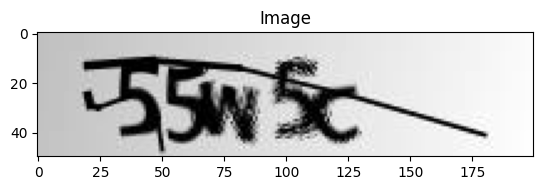

In [13]:
# plot the image
plt.imshow(X_train[idx].reshape((50, 200)), cmap='gray')
plt.title('Image')
plt.show()

In [14]:
# get the associated text
target_text = ''
for i in range(5):
    # get the index of the character with the highest probability
    ind = np.argmax(y_train[i][idx])
    # get the corresponding character from the symbols string
    char = symbols[ind]
    # append the character to the target text
    target_text += char

In [15]:
# display the associated text
print('Target Text: ', target_text)

Target Text:  55w5c


In [16]:
# set image shape
img_shape = (50, 200, 1)
def create_model():
    # define input layer with the given shape
    img = layers.Input(shape=img_shape)
    # Then the model has three convolutional layers with 16 and 32 filters, a 3x3 kernel same
    # add convolutional layer with 16 filters, 3x3 kernel, same padding and ReLU activation
    conv1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(img)
    # add max pooling layer with same padding and default pool size of 2x2
    mp1 = layers.MaxPooling2D(padding='same')(conv1)
    # add another convolutional layer with 32 filters, 3x3 kernel, same padding and ReLU activation
    conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp1)
    # add another max pooling layer with same padding
    mp2 = layers.MaxPooling2D(padding='same')(conv2)
    # add another convolutional layer with 32 filters, 3x3 kernel, same padding and ReLU activation
    conv3 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp2)
    # add batch normalization layer to normalize the inputs of the previous layer
    bn = layers.BatchNormalization()(conv3)
    # add another max pooling layer with same padding
    mp3 = layers.MaxPooling2D(padding='same')(bn)
    # flatten the output of the last max pooling layer
    flat = layers.Flatten()(mp3)
    # create an empty list to store outputs
    outs = []
    # repeat the following steps for each character in the CAPTCHA
    for _ in range(5):
        # add a dense layer with 64 units and ReLU activation
        dens1 = layers.Dense(64, activation='relu')(flat)
        # add a dropout layer with a dropout rate of 0.5 to prevent overfitting
        drop = layers.Dropout(0.5)(dens1)
        # add another dense layer with units equal to the number of possible symbols and sigmoid activation
        res = layers.Dense(num_symbols, activation='sigmoid')(drop)

        # add the output to the list of outputs
        outs.append(res)
    # define the model with the input and output layers
    model = Model(img, outs)
    # compile the model with categorical crossentropy loss and Adam optimizer
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])
    # return the model object
    return model
# create the model
model = create_model()

In [17]:
# print the model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50, 200, 1)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 50, 200, 16)          160       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 25, 100, 16)          0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 25, 100, 32)          4640      ['max_pooling2d[0][0]']   

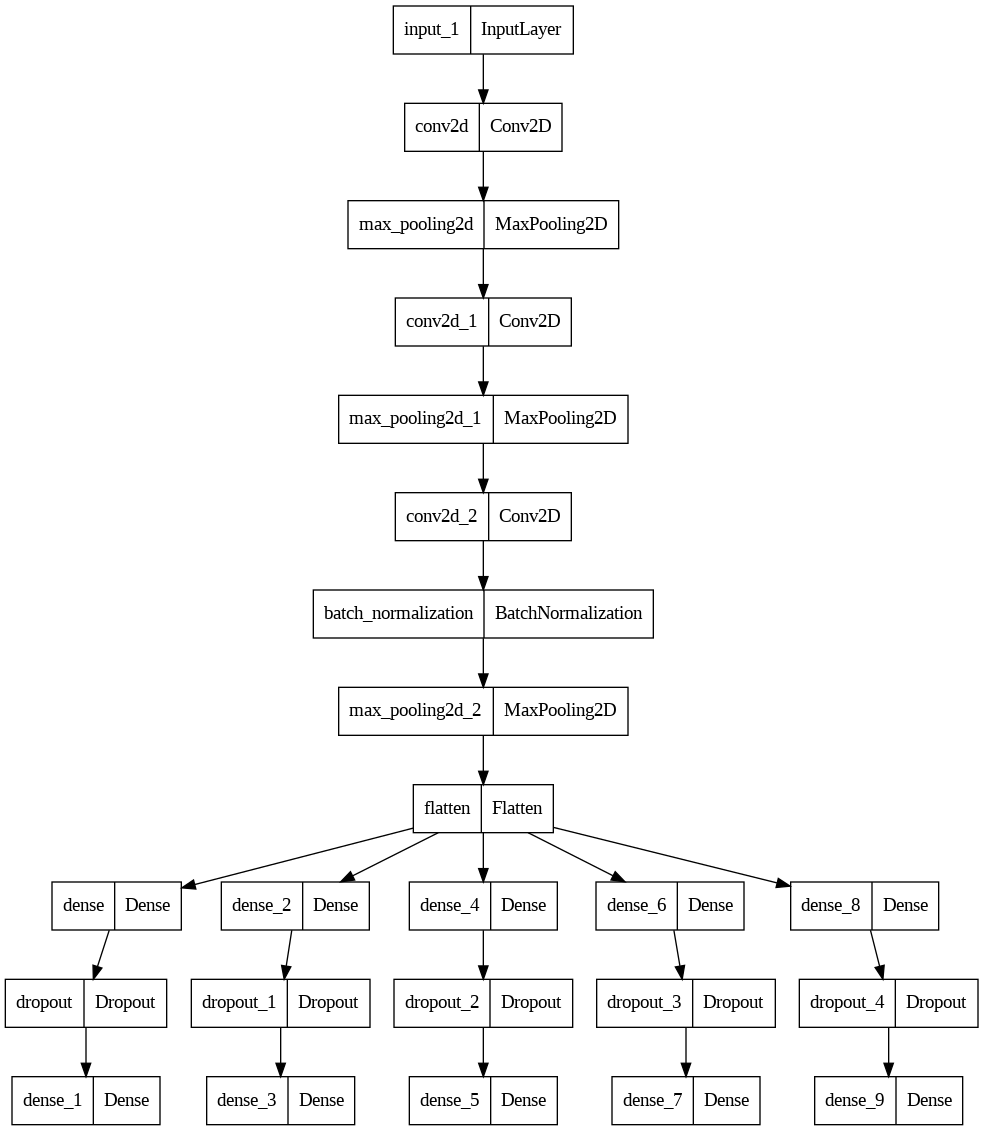

In [18]:
# Display the model architecture
plot_model(model, to_file='model.png')

In [23]:
# Define the filepath for saving the model
filepath = './gdrive/My Drive/ocr/ocr_weights.h5'

# Define the ModelCheckpoint callback to save the model during training
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min')

In [24]:
# Train the model with the added callback
hist = model.fit(X_train, [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]],
                 batch_size=32, epochs=150, verbose=1,
                 validation_data=(X_test, [y_test[0], y_test[1], y_test[2], y_test[3],
                                           y_test[4]]), callbacks=[checkpoint])

Epoch 1/150
20/24 [========================>.....] - ETA: 0s - loss: 5.0777 - dense_1_loss: 0.3989 - dense_3_loss: 1.0845 - dense_5_loss: 1.0799 - dense_7_loss: 1.0866 - dense_9_loss: 1.4278 - dense_1_accuracy: 0.8484 - dense_3_accuracy: 0.6187 - dense_5_accuracy: 0.6203 - dense_7_accuracy: 0.6078 - dense_9_accuracy: 0.4672
Epoch 1: val_loss improved from inf to 12.22954, saving model to ./gdrive/My Drive/ocr/ocr_weights.h5
24/24 [==============================] - 1s 25ms/step - loss: 5.0837 - dense_1_loss: 0.3886 - dense_3_loss: 1.0946 - dense_5_loss: 1.0679 - dense_7_loss: 1.0982 - dense_9_loss: 1.4344 - dense_1_accuracy: 0.8545 - dense_3_accuracy: 0.6195 - dense_5_accuracy: 0.6168 - dense_7_accuracy: 0.6088 - dense_9_accuracy: 0.4700 - val_loss: 12.2295 - val_dense_1_loss: 4.4753 - val_dense_3_loss: 1.7727 - val_dense_5_loss: 1.8443 - val_dense_7_loss: 2.0521 - val_dense_9_loss: 2.0850 - val_dense_1_accuracy: 0.2025 - val_dense_3_accuracy: 0.7383 - val_dense_5_accuracy: 0.7227 - val

In [27]:
# Loading the pretrained weights
model.load_weights("/content/gdrive/MyDrive/OCR-Captcha Recognition/ocr/ocr_weights.h5")

In [28]:
# Get list of image file paths in the directory
img_dir = '/content/gdrive/MyDrive/OCR-Captcha Recognition/prediction'
img_paths = [os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith('.png')]


In [29]:
def predict(filepath):
    """
    Function to predict the captcha given a file path

    Args:
    filepath (str): The file path of the captcha image

    Returns:
    capt (str): The predicted captcha
    """
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img = img / 255.0
    else:
        print("Not detected")

    res = np.array(model.predict(img[np.newaxis, :, :, np.newaxis]))
    ans = np.reshape(res, (5, 36))
    l_ind = []
    probs = []
    for a in ans:
        l_ind.append(np.argmax(a))
    capt = ''
    for l in l_ind:
        capt += symbols[l]
    return capt


1/1 [==============================] - 0s 256ms/step


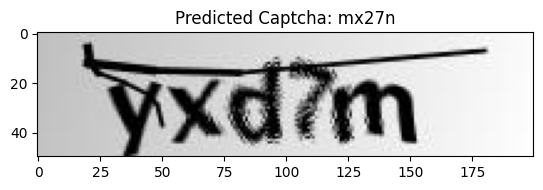

1/1 [==============================] - 0s 18ms/step


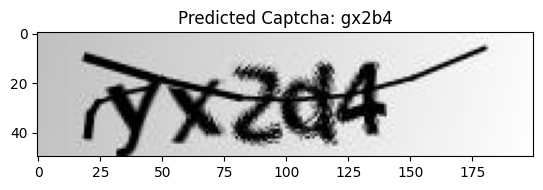

1/1 [==============================] - 0s 24ms/step


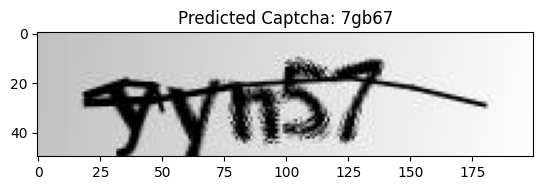

1/1 [==============================] - 0s 32ms/step


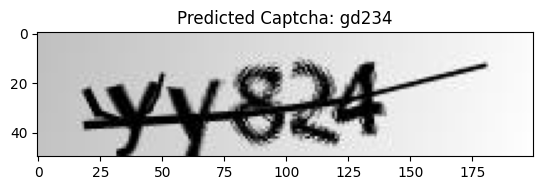

1/1 [==============================] - 0s 34ms/step


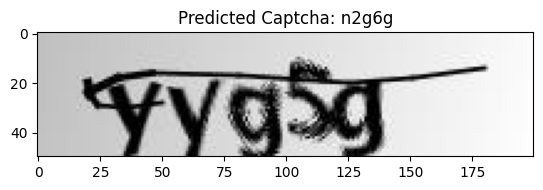

In [30]:
# Predict captcha for each image and display the result
for img_path in img_paths:
    captcha = predict(img_path)
    img = cv2.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title('Predicted Captcha: {}'.format(captcha))
    plt.show()

In [31]:
#Evaluate the performance of the trained model on the test data
score= model.evaluate(X_test,[y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]],verbose=1)
# Print the test loss and accuracy
print('Test Loss and accuracy:', score)

11/11 [==============================] - 0s 7ms/step - loss: 13.3907 - dense_1_loss: 4.0667 - dense_3_loss: 2.3694 - dense_5_loss: 2.2309 - dense_7_loss: 2.3021 - dense_9_loss: 2.4216 - dense_1_accuracy: 0.1900 - dense_3_accuracy: 0.6760 - dense_5_accuracy: 0.7009 - dense_7_accuracy: 0.6137 - dense_9_accuracy: 0.6791
Test Loss and accuracy: [13.390714645385742, 4.066687107086182, 2.3694229125976562, 2.2309248447418213, 2.3020670413970947, 2.4216127395629883, 0.19003115594387054, 0.6760124564170837, 0.7009345889091492, 0.6137071847915649, 0.6791277527809143]
